<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [54]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import re
import os
from collections import Counter
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
from scipy.sparse import csr_matrix
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['patch.force_edgecolor'] = True

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'data'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
t = pd.read_csv('data/3users/user0001.csv', parse_dates=['timestamp']).timestamp.values[0]
t = (t.astype('datetime64[h]'))
t.astype(object).weekday()

4

In [4]:
def get_dict(path_to_data, sites_dict_file, ids_dict_file):
    """Auxiliary function for sites counting dict building
    """
    
    arr = []
    '''Pull all visited sites from .csv logs to array'''
    for file in glob(path_to_data + '/*'):
        with open(file) as f:
            for line in f.readlines()[1:]:  # Exclude header
                arr.append(line.split(',')[1].strip())  # Add to list only sites
                
    '''Make counted sorted dict with sites and corresponding # of visits (freqency)'''
    sites_freq_list = sorted(Counter(arr).items(), 
                             key=lambda x: x[1], reverse=True)
    '''Make sites dict in form of {'site': [id, frequency]}'''
    sites_dict = dict(
        (s, [i, freq]) for i, (s, freq) in enumerate(sites_freq_list, 1)
    )
    '''Make id to site converter'''
    id_to_site_dict = dict((val[0], key) for key, val in sites_dict.items())
    id_to_site_dict[0] = 'no_site'

    '''Save dict to file'''
    with open(sites_dict_file, 'wb') as fout:
        pickle.dump(sites_dict, fout)

    with open(ids_dict_file, 'wb') as fout:
        pickle.dump(id_to_site_dict, fout)

    return sites_dict, id_to_site_dict


def prepare_sites_dict(path_to_data, sites_dict_file=os.path.join(PATH_TO_DATA, 'sites_dict.pkl'),
                       ids_dict_file=os.path.join(PATH_TO_DATA, 'ind_to_sites_dict.pkl'),
                       refresh=False):
    """Func to get dictionaries for converting site's name to it's index.
        
        If dictionary for data in PATH_TO_DATA has already been compiled, 
        functions just pickle dict out of files.
        
    """
    
    # Initial part of the function
    try:
        with open(sites_dict_file, 'rb') as input_file:
            sites_dict = pickle.load(input_file)
            
        with open(ids_dict_file, 'rb') as input_file:
            id_to_site_dict = pickle.load(input_file)
            
    except FileNotFoundError:
        sites_dict, id_to_site_dict = get_dict(path_to_data, sites_dict_file, ids_dict_file)
        
    if refresh:
        sites_dict, id_to_site_dict = get_dict(path_to_data, sites_dict_file, ids_dict_file)
        
    return sites_dict, id_to_site_dict

In [5]:
def to_csr(X):
    session_length = X.shape[1]
    data = [1] * X.ravel().shape[0]
    indices = X.ravel()
    indptr = range(0, X.ravel().shape[0] + session_length, session_length)
    return csr_matrix((data, indices, indptr))[:, 1:]

In [6]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path,
                              session_length=10, window_size=10,
                              refresh_dict=False, return_table=False):
    """Func for partition users logs to desireable num of sessions
        and prepare training dataset with sessions of particular users.
    """
    
    df = pd.DataFrame()
    
    sites_dict, _ = prepare_sites_dict(path_to_csv_files,
                                       sites_dict_file=site_freq_path,
                                       refresh=refresh_dict)
    
    for file in tqdm(glob(path_to_csv_files + '/*'), desc='Preparing training set...'):
            
        temp_df = pd.read_csv(file, parse_dates=['timestamp'])
        temp_df['site_id'] = temp_df.site.apply(lambda x: sites_dict[x][0])
        
        '''Feature generating with sliding window'''
        windptr = range(0, temp_df.shape[0], window_size)
        sessions = []  # Sites in a session row
        timedeltas = []  # Time of the session
        uniques = []  # Number of unique sites in the session
        start_hours = []  # Session start hour
        days_of_week = []  # Session start weekday
        for ptr in windptr:
            sess = temp_df.site_id.values[ptr:ptr+session_length]
            if len(sess) < session_length:  # All incomplete session windows are being completed by zeros
                sess = np.r_[sess, [0] * (session_length - len(sess))]
                
            sessions = np.r_[sessions, sess]
            
            uniques.append(len(set(sess)))
            
            timespan = temp_df.timestamp.values[ptr:ptr+session_length]
            timedeltas.append((timespan[-1] - timespan[0]) / np.timedelta64(1, 's'))
            
            start_time = timespan[0].astype('datetime64[h]').astype(object)
            start_hours.append(start_time.hour)
            
            days_of_week.append(start_time.weekday())
            
        '''Preparing the columns'''
        sessions = sessions.reshape(-1, session_length)  # Partition user data to sessions
        timedeltas = np.asarray(timedeltas, dtype=np.int32).reshape(sessions.shape[0], 1)
        uniques = np.asarray(uniques, dtype=np.int8).reshape(sessions.shape[0], 1)
        start_hours = np.asarray(start_hours, dtype=np.int8).reshape(sessions.shape[0], 1)
        days_of_week = np.asarray(days_of_week, dtype=np.int8).reshape(sessions.shape[0], 1)
        
        '''Build a full dataset consisting of user id's and sessions'''
        feature_names = ['site'+ str(x+1) for x in range(session_length)] + \
                        ['session_timespan', '#unique_sites', 'start_hour', 
                         'day_of_week']
        temp_df = pd.DataFrame(np.hstack((sessions, timedeltas, uniques, start_hours, days_of_week)),
                               columns=feature_names, dtype=np.int32)
        
        '''Find user's id [target feature] in the file name'''
        user_id = re.findall(r'\d+', file)[-1]
        temp_df['user_id'] = [int(user_id)] * temp_df.shape[0]
        
        df = df.append(temp_df, ignore_index=True)
        
    if return_table:
        return df
    else:
        X_sites, X_add, y = df.iloc[:, :-5].values, df.iloc[:, -5:-1].values, df.iloc[:, -1].values
        return to_csr(X_sites), X_add, y

**Проверим функцию на игрушечном примере.**

In [7]:
X_sites, X_add, y = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users'), 
                          site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                          session_length=10,
                          window_size=5,
                          refresh_dict=True)

Preparing training set...: 100%|██████████| 3/3 [00:00<00:00, 309.60it/s]


In [8]:
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                  session_length=10, refresh_dict=True, return_table=True)

Preparing training set...: 100%|██████████| 3/3 [00:00<00:00, 312.08it/s]


In [9]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,3,2,2,7,2,1,8,5,9,10,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60,3,12,4,1
2,3,2,6,6,2,0,0,0,0,0,7935,4,9,4,2
3,4,1,2,1,2,1,1,5,11,4,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471,4,12,4,3


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [11]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'),
                                               os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                               return_table=True)

Preparing training set...: 100%|██████████| 10/10 [00:00<00:00, 10.72it/s]

CPU times: user 916 ms, sys: 25.1 ms, total: 941 ms
Wall time: 938 ms


In [14]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,192,574,133,3,133,133,3,133,203,133,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [15]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'),
                                                os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                                return_table=True)

Preparing training set...: 100%|██████████| 150/150 [00:09<00:00, 15.28it/s]

CPU times: user 9.24 s, sys: 617 ms, total: 9.85 s
Wall time: 9.84 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [16]:
new_features_10users = train_data_10users.iloc[:, -5:-1]
new_features_150users = train_data_150users.iloc[:, -5:-1]

In [18]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [35]:
new_features_10users.describe().astype(int).loc['50%']['session_timespan']

37

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [38]:
print('2 is Wednesday')
new_features_10users.describe().astype(int).loc['50%']['day_of_week']

2 is Wednesday


2

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [41]:
new_features_150users.describe().astype(int).loc['50%']['start_hour']

13

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [44]:
new_features_150users.describe().astype(int).loc['50%']['#unique_sites']

7

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [48]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

In [49]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

In [51]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,192,574,133,3,133,133,3,133,203,133,33,5,8,4,John
1,415,193,674,254,133,31,393,3305,217,55,284,10,8,4,John
2,55,3,55,55,5,293,415,333,897,55,258,7,8,4,John
3,473,3306,473,55,55,55,55,937,199,123,30,6,8,4,John
4,342,55,5,3307,258,211,3308,2086,675,2086,6,9,8,4,John


**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

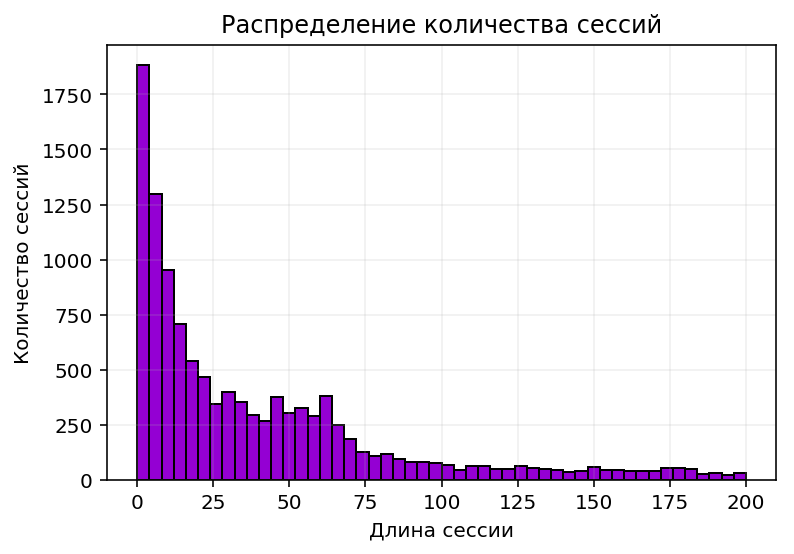

In [85]:
hist_data = train_data_10users['session_timespan']
plt.hist(hist_data, bins=50, range=(0,200), color='darkviolet')
plt.grid(True, alpha=.2)
plt.xlabel('Длина сессии, с')
plt.ylabel('Количество сессий')
plt.title('Распределение количества сессий');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

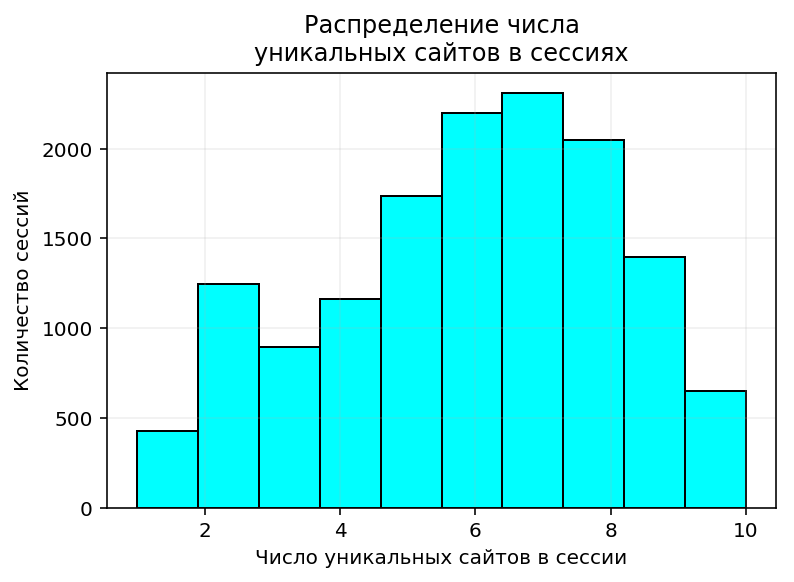

In [98]:
hist_data = train_data_10users['#unique_sites']
plt.hist(hist_data, color='aqua')
plt.grid(True, alpha=.2)
plt.xlabel('Число уникальных сайтов в сессии')
plt.ylabel('Количество сессий')
plt.title('Распределение числа\nуникальных сайтов в сессиях');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [202]:
user_list = train_data_10users.user_id.unique()
color_dict = dict(
    (user, color) for user, color in zip(user_list, cm.rainbow_r(np.linspace(0, 1, len(user_list))))
)

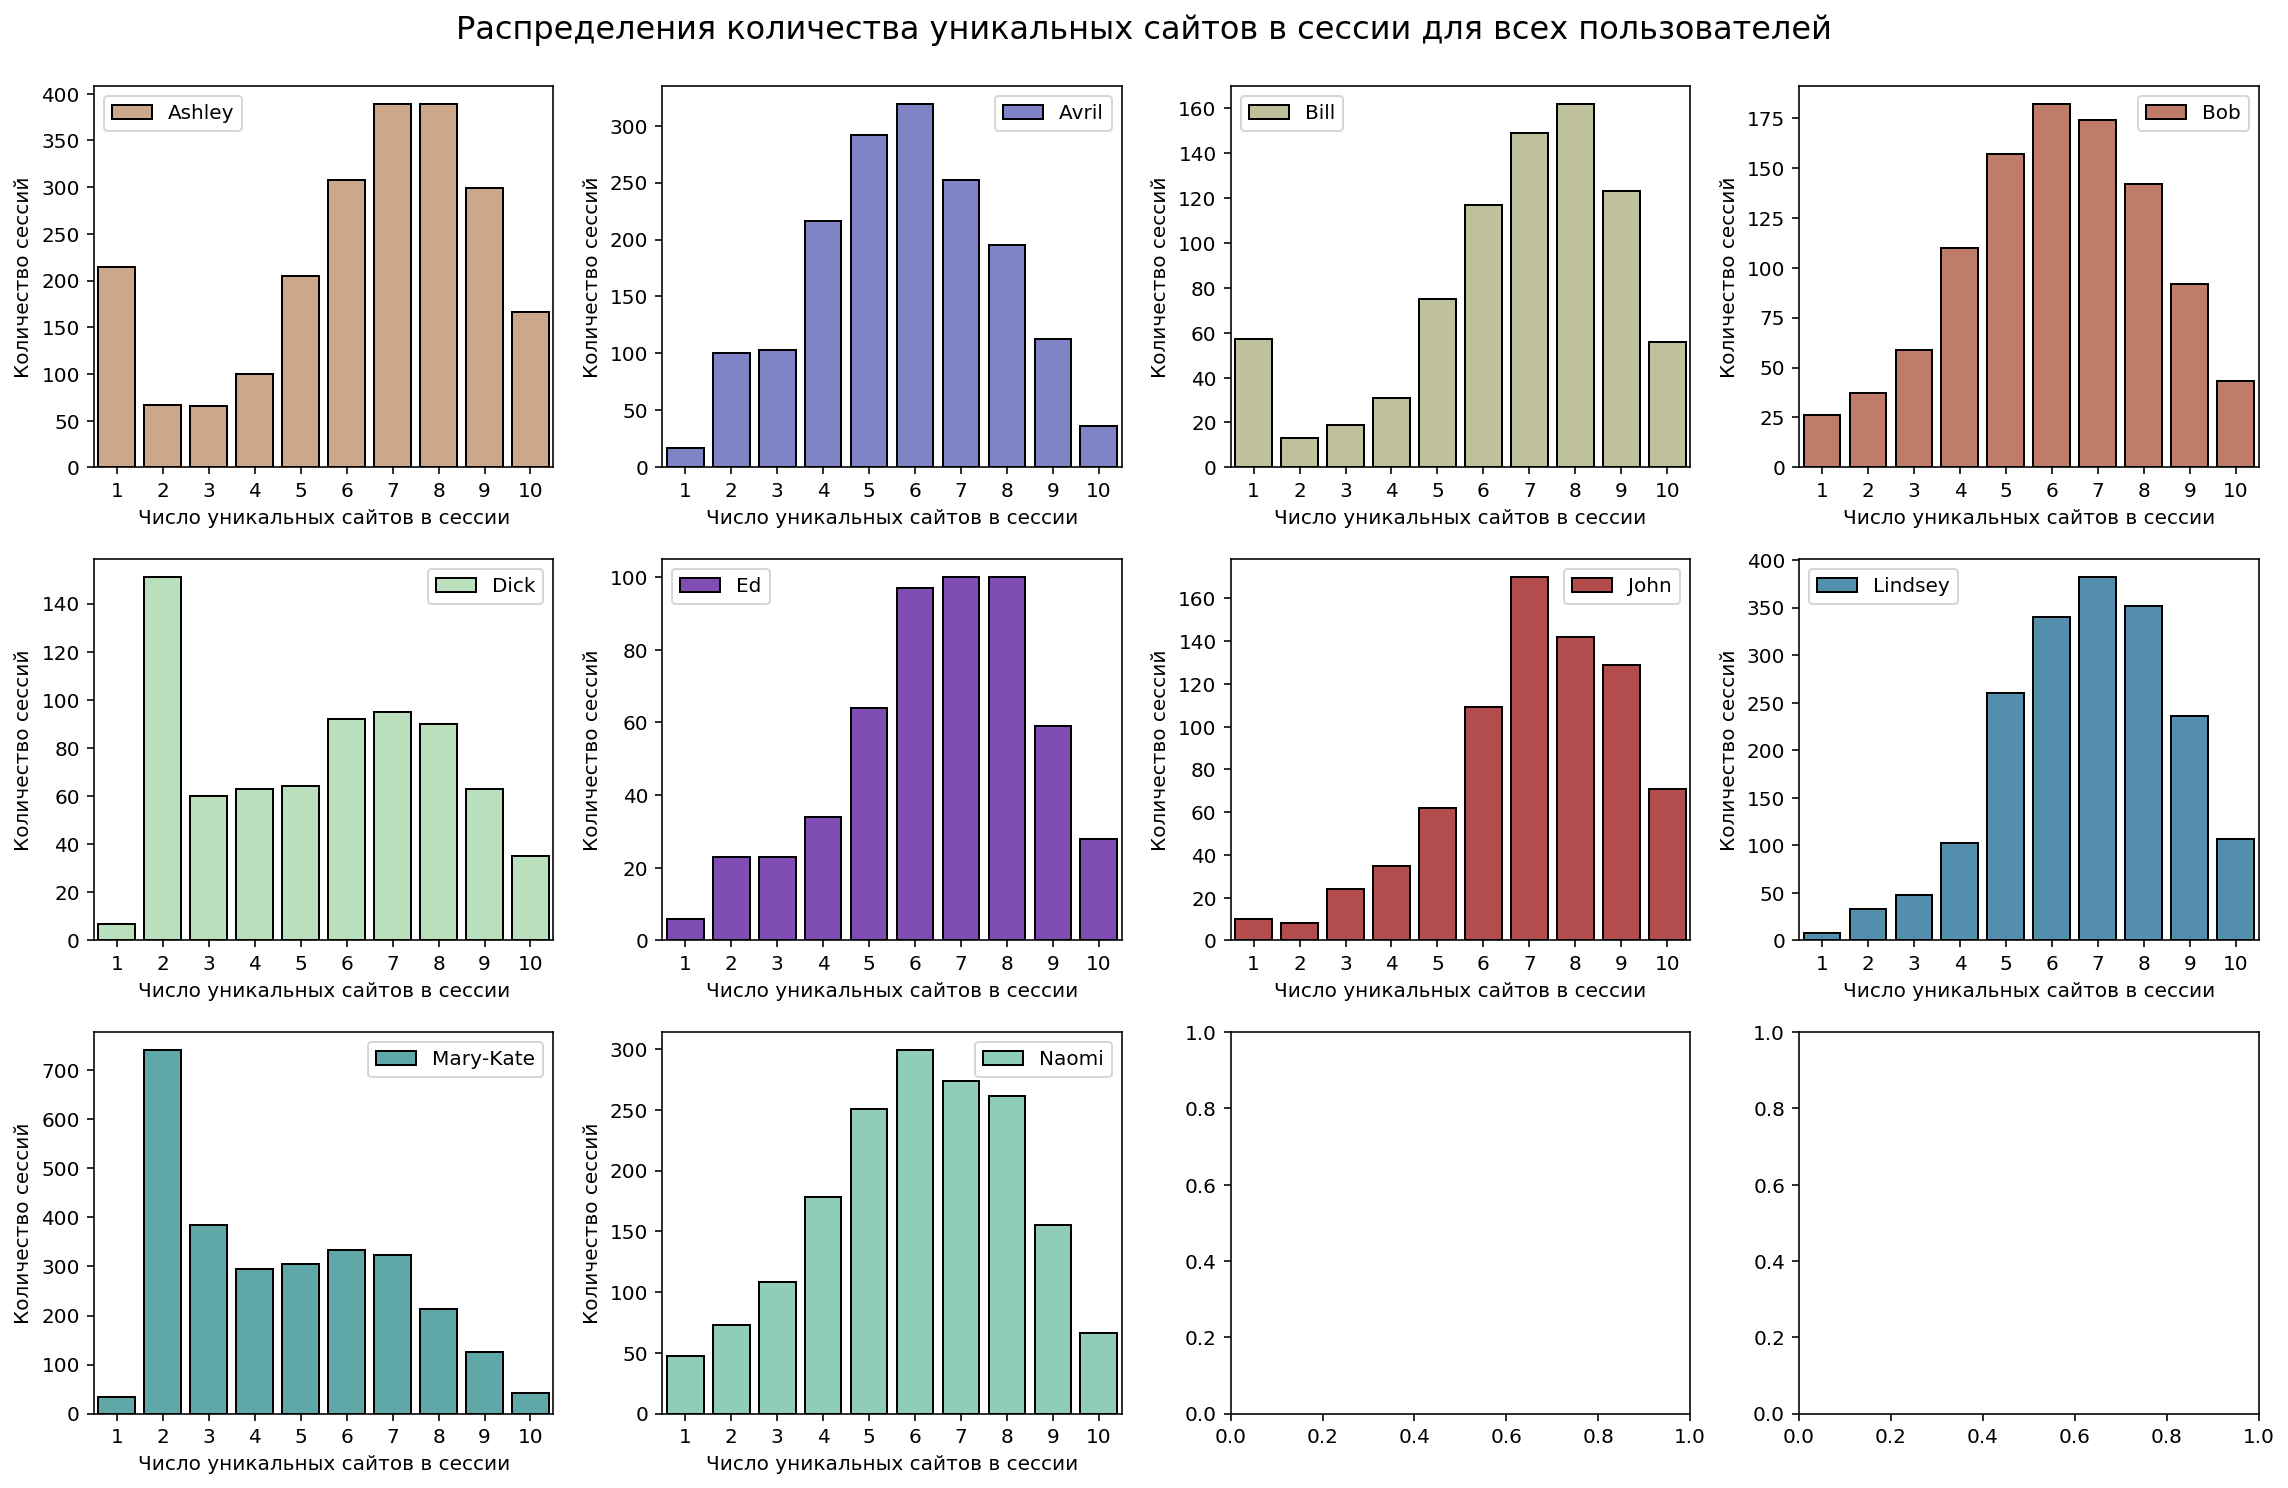

In [305]:
import matplotlib.cm as cm
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
colors = cm.rainbow_r(np.linspace(0, 1, 10))
for idx, (user, sub_df) in enumerate(pd.groupby(train_data_10users, 'user_id')): 
    s = sns.countplot(sub_df['#unique_sites'], color=color_dict[user], saturation=.4, ax=ax[idx//4, idx%4], label=user)
    s.set_xlabel('Число уникальных сайтов в сессии')
    s.set_ylabel('Количество сессий')
    s.legend()
    
fig.suptitle('Распределения количества уникальных сайтов в сессии для всех пользователей', y=1.03,
             fontsize=16)
fig.tight_layout();

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

In [287]:
train_data_10users['start_hour'].unique()

array([ 8,  9, 12, 15, 17, 16, 14, 10, 13, 11, 18, 20, 21, 23, 19, 22,  7])

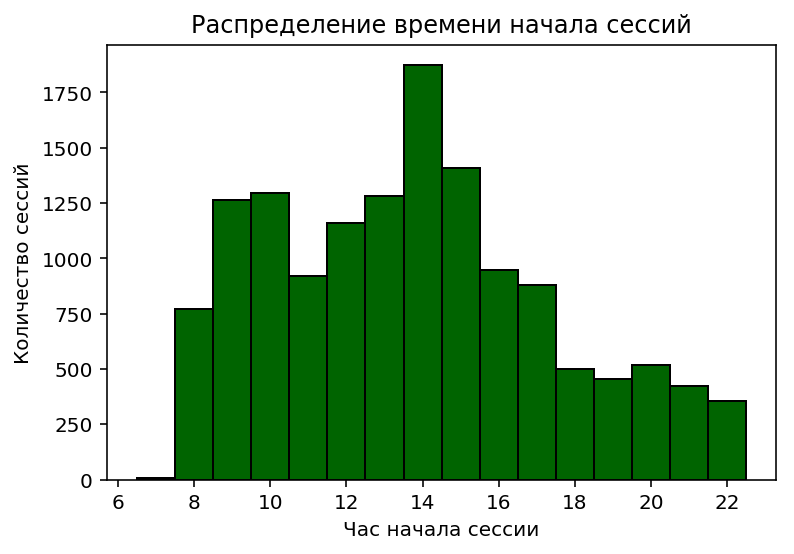

In [291]:
hist_data = train_data_10users['start_hour']
plt.hist(hist_data, bins=16, color='darkgreen', align='left')
plt.xlabel('Час начала сессии')
plt.ylabel('Количество сессий')
plt.title('Распределение времени начала сессий');

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

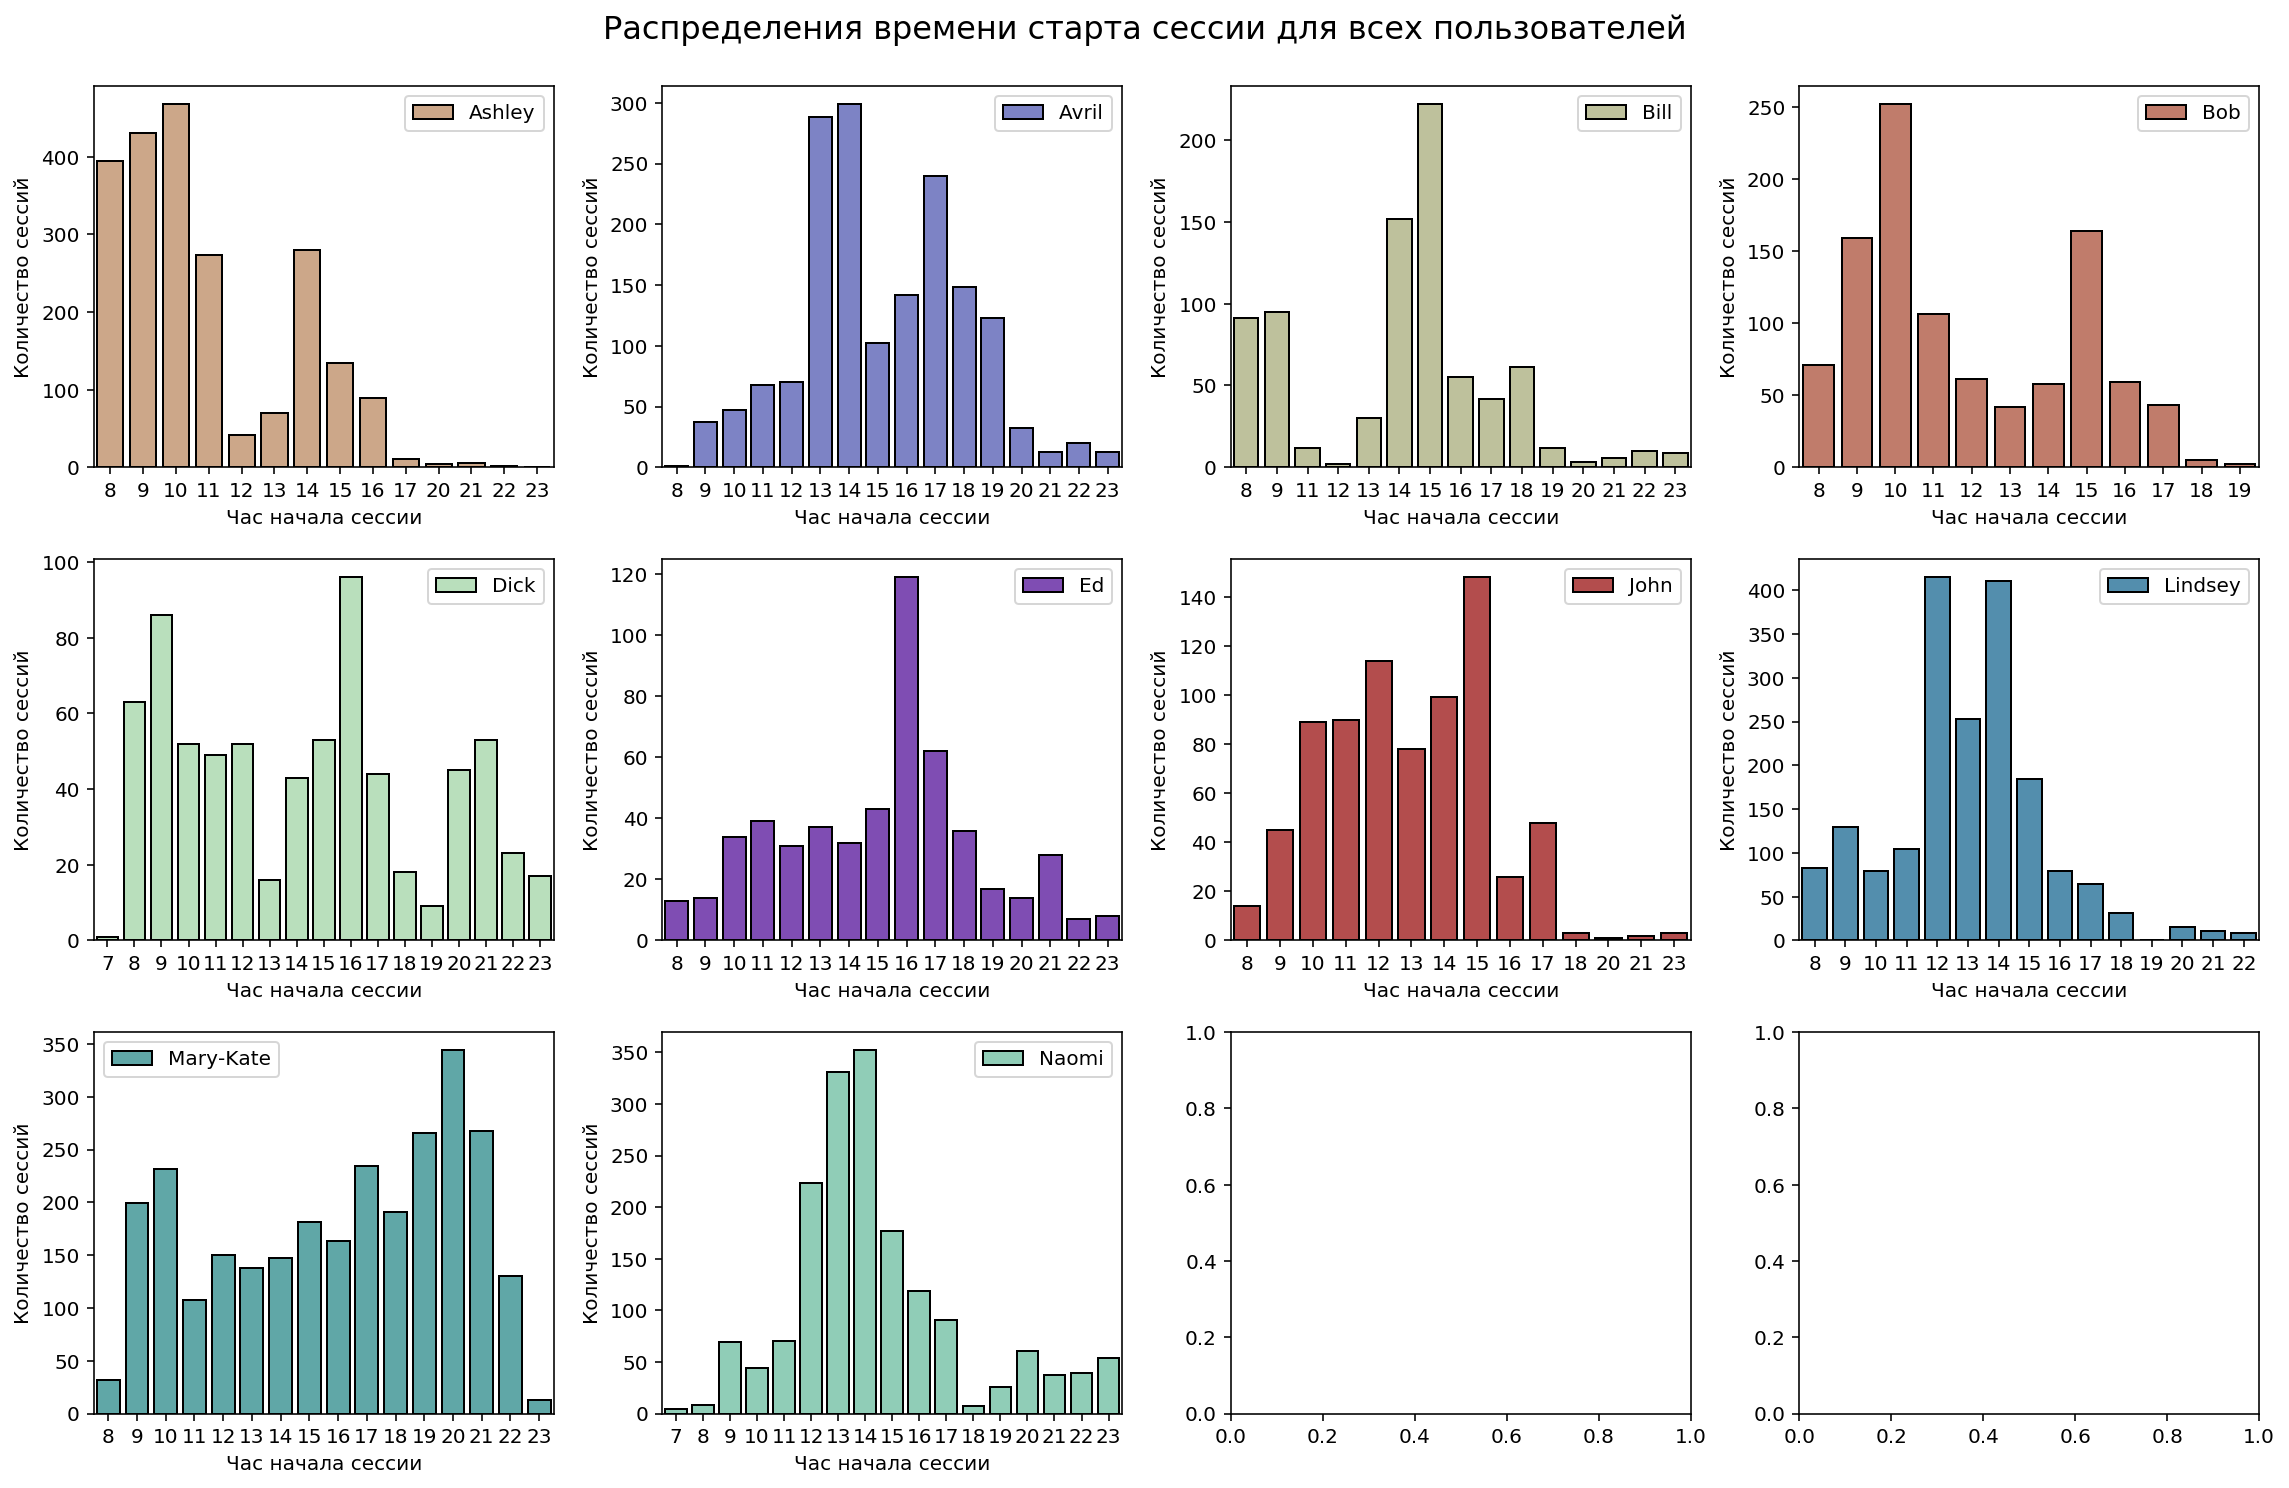

In [302]:
import matplotlib.cm as cm
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
colors = cm.Greens(np.linspace(0, 1, 12))
for idx, (user, sub_df) in enumerate(pd.groupby(train_data_10users, 'user_id')):
    s = sns.countplot(sub_df.start_hour, color=color_dict[user], saturation=.4, ax=ax[idx//4, idx%4], label=user)
    s.set_xlabel('Час начала сессии')
    s.set_ylabel('Количество сессий')
    s.legend()
    
fig.suptitle('Распределения времени старта сессии для всех пользователей', y=1.03,
             fontsize=16)
fig.tight_layout();

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

In [231]:
import seaborn as sns

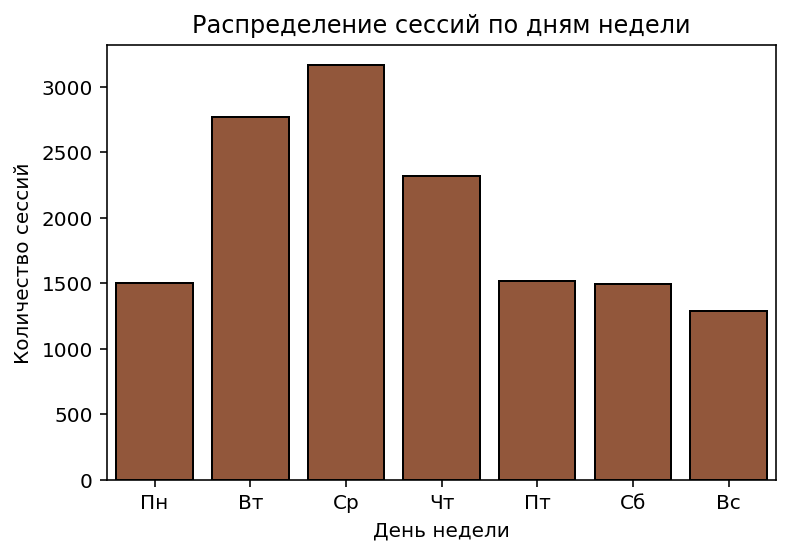

In [249]:
hist_data = train_data_10users['day_of_week']
s = sns.countplot(hist_data, color='sienna')
s.set_xlabel('День недели')
s.set_ylabel('Количество сессий')
s.set_xticklabels(['Пн','Вт','Ср','Чт','Пт','Сб','Вс'])
s.set_title('Распределение сессий по дням недели');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

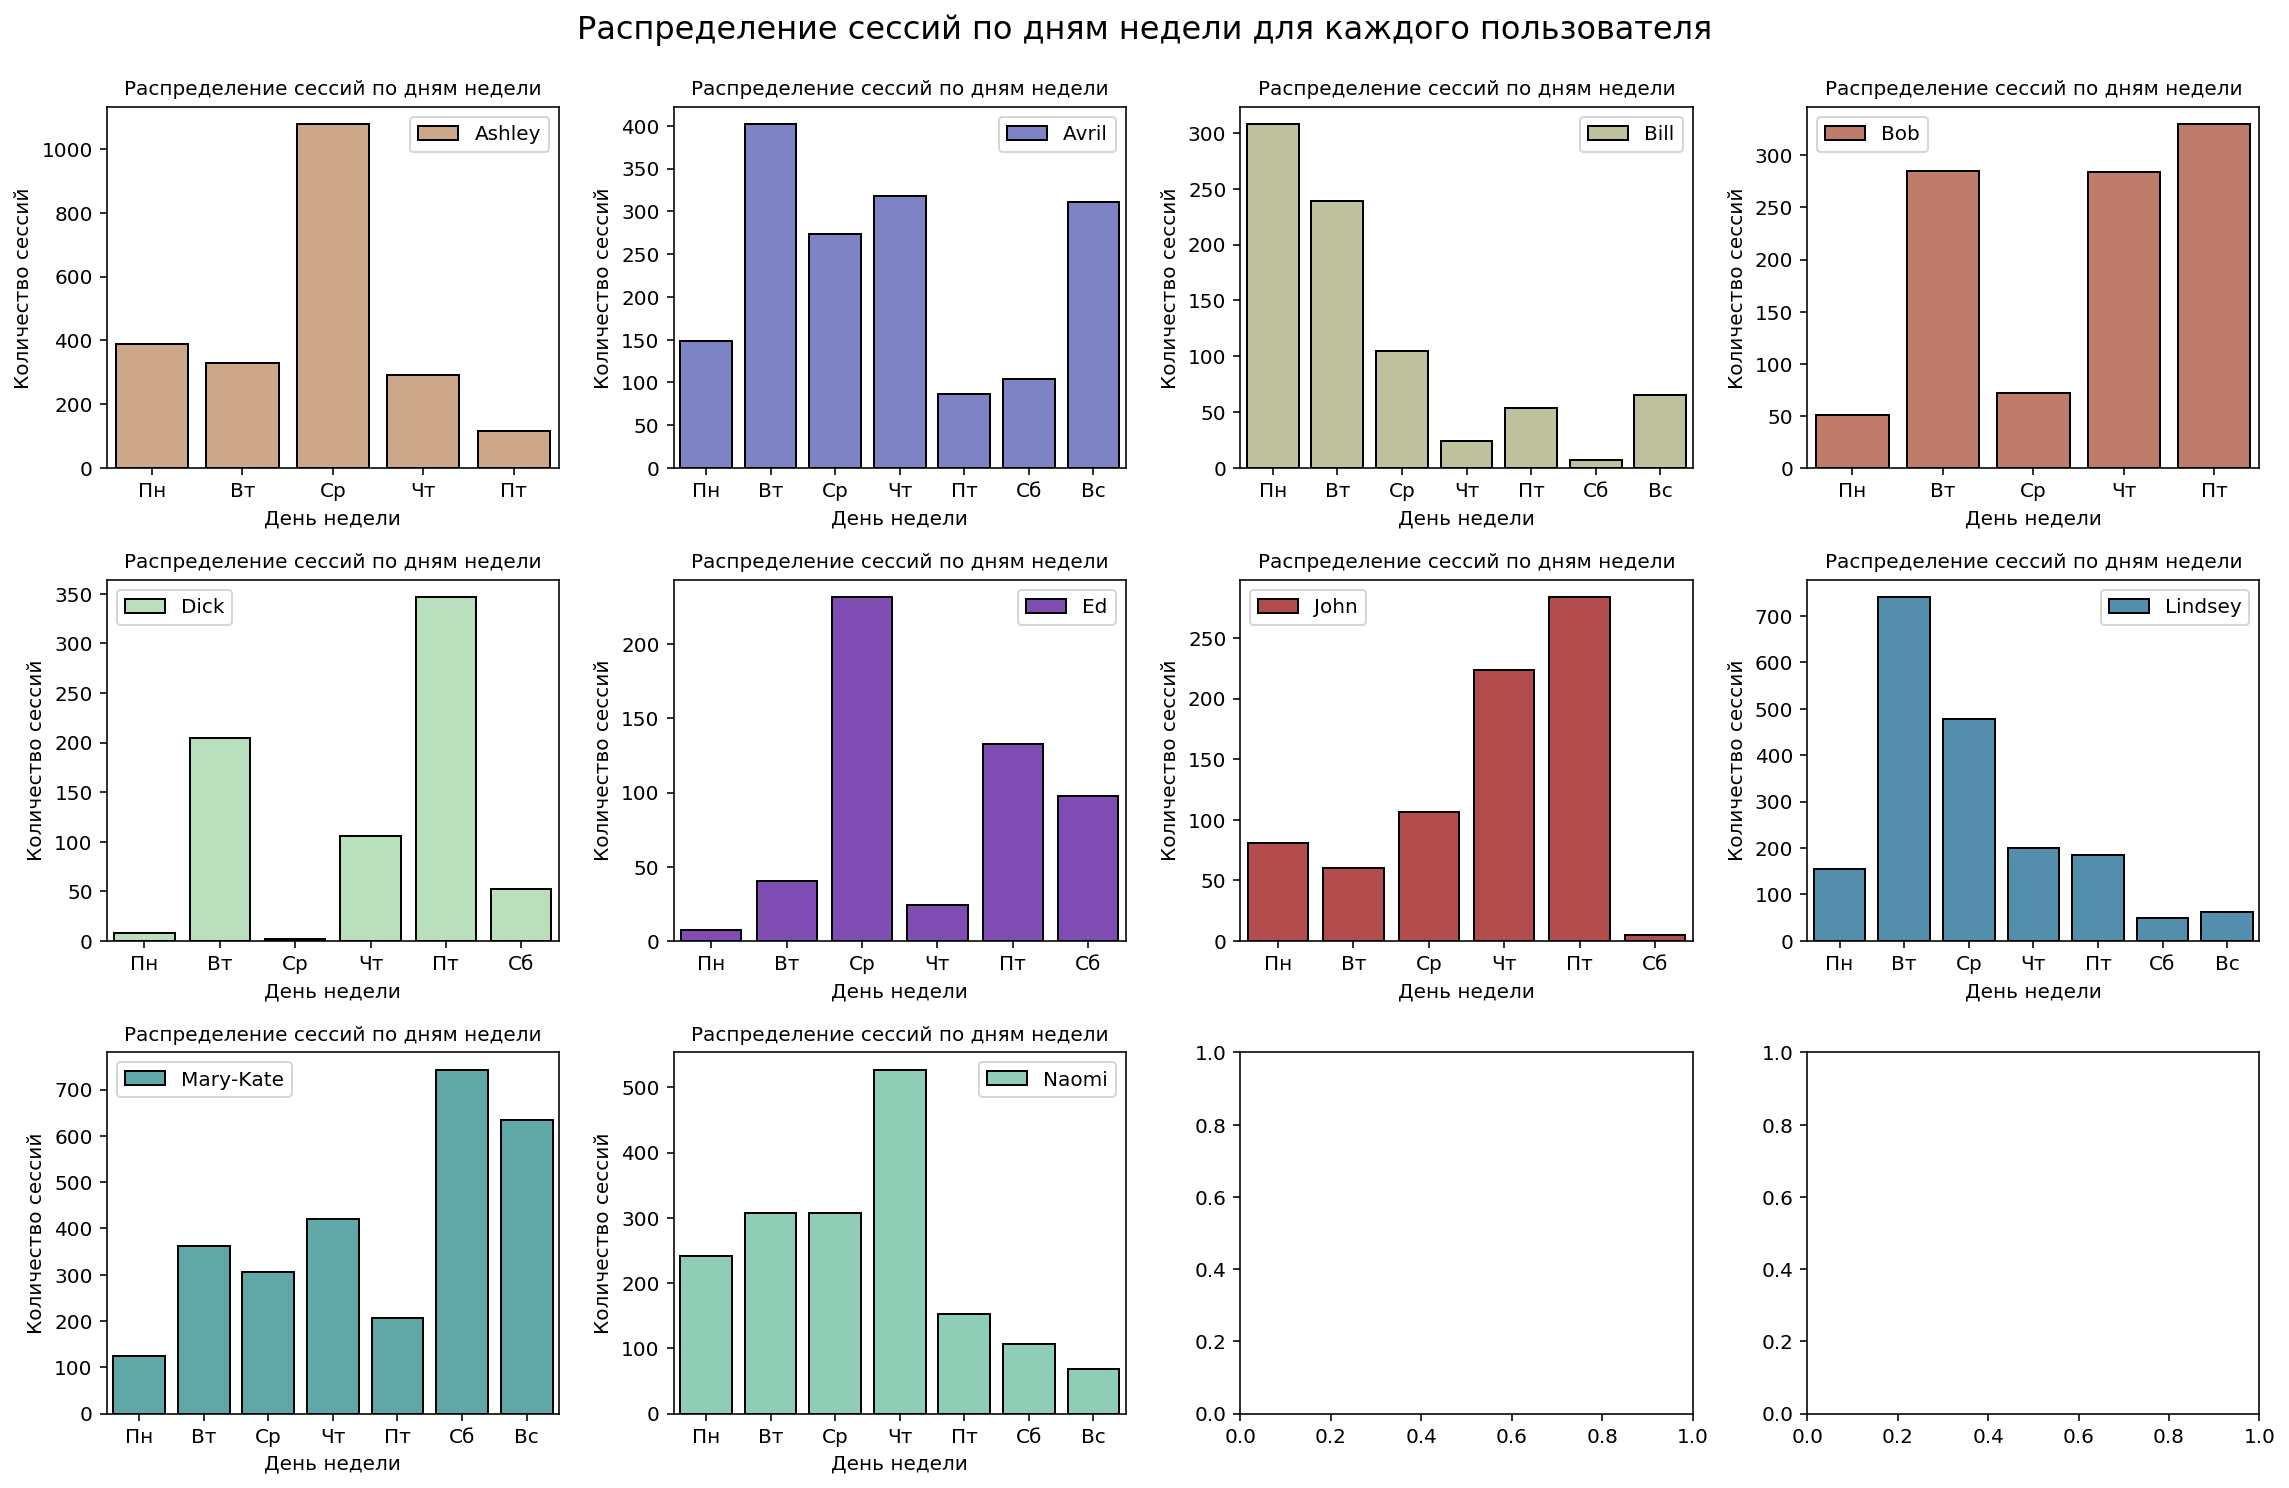

In [301]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    s = sns.countplot(sub_df.day_of_week, color=color_dict[user], saturation=.4, ax=ax[idx//4, idx%4], label=user)
    s.set_xlabel('День недели')
    s.set_ylabel('Количество сессий')
    s.legend()
    s.set_xticklabels(['Пн','Вт','Ср','Чт','Пт','Сб','Вс'])
    s.set_title('Распределение сессий по дням недели', fontsize=10)

fig.suptitle('Распределение сессий по дням недели для каждого пользователя', y=1.03, fontsize=16)
fig.tight_layout();

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [ ]:
with open ''' ВАШ КОД ЗДЕСЬ '''

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [ ]:
top10_freqs = ''' ВАШ КОД ЗДЕСЬ '''
top10_sites = ''' ВАШ КОД ЗДЕСЬ '''

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

In [ ]:
sns.barplot ''' ВАШ КОД ЗДЕСЬ '''

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 